# Feature Engineering

## Imports


In [2]:
import sys
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import rioxarray as rxr
import seaborn as sns
import xarray as xr


### First party modules


In [3]:
# Get the project root
ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

In [4]:
from scripts.data_wrangling import concat_csv_files  # type: ignore
from src.data import filter_by_date_range, make_date_columns  # type: ignore

### Optional packages

In [5]:
try:
    from catppuccin import PALETTE  # Just for aesthetic proposes
    catppuccin_imported = True
except ImportError:
    print("The catppuccin package is not installed, no matter :), plots will use the default visual configuration.")
    catppuccin_imported = False

In [6]:
if catppuccin_imported:
    # Choose a flavor (latte, frappe, macchiato, mocha)
    flavor = PALETTE.mocha

    # Extract colors as hex values in a dict for easy access
    colors = {
        color.name.lower().replace(" ", "_"): color.hex for color in flavor.colors
    }

    # Define color cycle for plots (select the colors you want to use)
    color_cycle = [
        colors["blue"],
        colors["pink"],
        colors["green"],
        colors["yellow"],
        colors["red"],
        colors["teal"],
        colors["peach"],
        colors["mauve"],
        colors["lavender"],
    ]

    # Configure matplotlib
    plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_cycle)
    plt.rcParams["axes.facecolor"] = "white"  # Set axes background to white
    plt.rcParams["figure.facecolor"] = "white"  # Set figure background to white
    plt.rcParams["text.color"] = colors["text"]
    plt.rcParams["axes.labelcolor"] = colors["text"]
    plt.rcParams["xtick.color"] = colors["subtext_1"]
    plt.rcParams["ytick.color"] = colors["subtext_1"]
    plt.rcParams["axes.edgecolor"] = colors["surface_2"]
    plt.rcParams["grid.color"] = colors["surface_0"]  # Catppuccin white for grid

    # Configure seaborn
    sns.set_palette(color_cycle)
    sns.set_style(
        {
            "axes.facecolor": colors["mantle"],  # Set axes background to white
            "figure.facecolor": colors["mantle"],  # Set figure background to white
            "text.color": colors["text"],
            "axes.labelcolor": colors["text"],
            "xtick.color": colors["subtext_1"],
            "ytick.color": colors["subtext_1"],
            "axes.edgecolor": colors["surface_2"],
            "grid.color": colors["surface_0"],  # Catppuccin white for grid
        },
    )


else:
    sns.set_theme(style="darkgrid")

In [7]:
{
    "rosewater": "#f5e0dc",
    "flamingo": "#f2cdcd",
    "pink": "#f5c2e7",
    "mauve": "#cba6f7",
    "red": "#f38ba8",
    "maroon": "#eba0ac",
    "peach": "#fab387",
    "yellow": "#f9e2af",
    "green": "#a6e3a1",
    "teal": "#94e2d5",
    "sky": "#89dceb",
    "sapphire": "#74c7ec",
    "blue": "#89b4fa",
    "lavender": "#b4befe",
    "text": "#cdd6f4",
    "subtext_1": "#bac2de",
    "subtext_0": "#a6adc8",
    "overlay_2": "#9399b2",
    "overlay_1": "#7f849c",
    "overlay_0": "#6c7086",
    "surface_2": "#585b70",
    "surface_1": "#45475a",
    "surface_0": "#313244",
    "base": "#1e1e2e",
    "mantle": "#181825",
    "crust": "#11111b",
}

{'rosewater': '#f5e0dc',
 'flamingo': '#f2cdcd',
 'pink': '#f5c2e7',
 'mauve': '#cba6f7',
 'red': '#f38ba8',
 'maroon': '#eba0ac',
 'peach': '#fab387',
 'yellow': '#f9e2af',
 'green': '#a6e3a1',
 'teal': '#94e2d5',
 'sky': '#89dceb',
 'sapphire': '#74c7ec',
 'blue': '#89b4fa',
 'lavender': '#b4befe',
 'text': '#cdd6f4',
 'subtext_1': '#bac2de',
 'subtext_0': '#a6adc8',
 'overlay_2': '#9399b2',
 'overlay_1': '#7f849c',
 'overlay_0': '#6c7086',
 'surface_2': '#585b70',
 'surface_1': '#45475a',
 'surface_0': '#313244',
 'base': '#1e1e2e',
 'mantle': '#181825',
 'crust': '#11111b'}

## Load Data

### Load production data

In [8]:
# Change for "../data/raw/daily_energy_production.csv" for a classic path
raw_data_directory = ROOT_DIR / "data" / "raw"
processed_data_directory = ROOT_DIR / "data" / "processed"

demand_path = raw_data_directory / "hourly_demand.csv"
sample_month_path = processed_data_directory / "csv_files" / "2024-12.csv"
historic_hourly_path = processed_data_directory / "generation_historic_subtipo.csv"
historic_hourly_tipo_path = processed_data_directory / "generation_historic_tipo.csv"
# historic_daily_path = raw_data_directory / "daily_energy_production.csv"

demand = pd.read_csv(demand_path)
# sample_month = pd.read_csv(sample_month_path)
historic = pd.read_csv(historic_hourly_path)
historic_tipo = pd.read_csv(historic_hourly_tipo_path)
# historic_daily = pd.read_csv(historic_daily_path)

In [9]:
demand["demanda"] = pd.to_numeric(demand["demanda"].str.replace(",", "."))

### Load weather data

In [10]:
# Shape of regions
regions_chile_path = raw_data_directory / "Regiones" / "Regional.shp"
regions_gdf = gpd.read_file(regions_chile_path)

# Load weather data
weather_path = raw_data_directory / "Weather"
radiation_clouds_path = weather_path / "radiation_clouds.grib"
radiation = xr.open_dataset(radiation_clouds_path, engine="cfgrib", filter_by_keys={"shortName": "ssrd"})
clouds = xr.open_dataset(radiation_clouds_path, engine="cfgrib", filter_by_keys={"shortName": "tcc"})

/home/kyoumas/repos/ts_energy_patterns/.venv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/kyoumas/repos/ts_energy_patterns/.venv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [ ]:
regions_gdf = regions_gdf.to_crs("EPSG:4326")

### Getting regions weather data

In [ ]:
regions = regionmask.from_geopandas(regions_gdf, names="Region", overlap=False)
mask = regions.mask(radiation.longitude, radiation.latitude)
masked_ds = radiation.where(mask.notnull())
masked_ds.to_netcdf(processed_data_directory / "masked_ssrd.nc")

In [12]:
region_names = regions_gdf['Region'].tolist()
time_coords = []
ssrd_data = []

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
from tqdm import tqdm

ds = radiation
region_count = 1

def process_time_step(t_s):
    t, s = t_s
    valid_time = pd.to_datetime(ds.valid_time.isel(time=t, step=s).values)
    ssrd_slice = ds.ssrd.isel(time=t, step=s)

    region_means = []
    for region_id in range(region_count):
        region_mask = (mask == region_id)
        region_mean = ssrd_slice.where(region_mask).mean(skipna=True).values
        region_means.append(region_mean)

    return valid_time, region_means

# Generate all (time, step) pairs
tasks = [(t, s) for t in range(ds.sizes["time"]) for s in range(ds.sizes["step"])]

# Run in parallel
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_time_step, task) for task in tasks]
    for f in tqdm(as_completed(futures), total=len(futures), desc="Processing time/step"):
        results.append(f.result())

time_coords, ssrd_data = zip(*results)

df = pd.DataFrame(
    data=ssrd_data,
    index=pd.DatetimeIndex(time_coords, name="datetime"),
    columns=region_names,
)


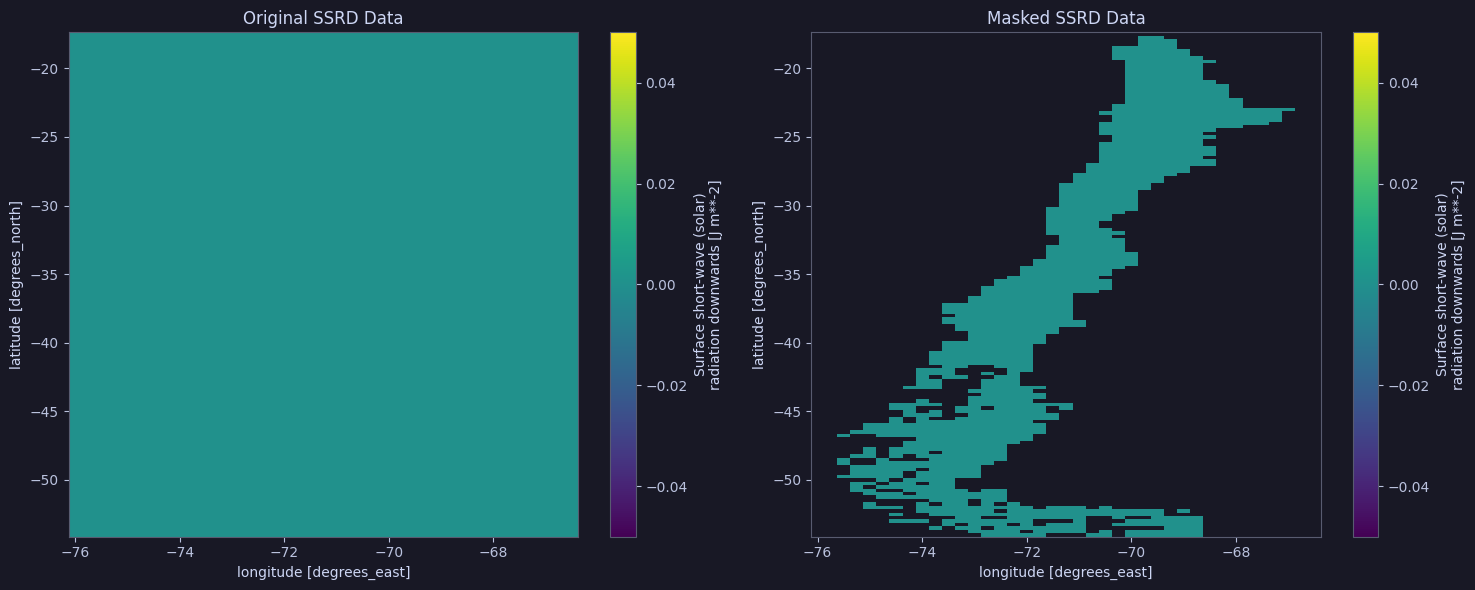

Original data shape: (3928, 12, 147, 39)
Masked data shape: (3928, 12, 147, 39)
Number of regions in shapefile: 17
Region names: ['Región de Arica y Parinacota', 'Región de Tarapacá', 'Región de Antofagasta', 'Región de Magallanes y Antártica Chilena', 'Región de Aysén del Gral.Ibañez del Campo', 'Región de Atacama', 'Región de Coquimbo', 'Región de Valparaíso', 'Región Metropolitana de Santiago', 'Región de Los Lagos', 'Región de Los Ríos', 'Región de La Araucanía', 'Región del Bío-Bío', 'Región de Ñuble', 'Región del Maule', "Región del Libertador Bernardo O'Higgins", 'Zona sin demarcar']


In [ ]:
ds = radiation
gdf = regions_gdf

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original data (first time step, first forecast step)
ds.ssrd.isel(time=1, step=1).plot(ax=axes[0], cmap='viridis')
axes[0].set_title('Original SSRD Data')

# Masked data
masked_ds.ssrd.isel(time=1, step=1).plot(ax=axes[1], cmap='viridis')
axes[1].set_title('Masked SSRD Data')

plt.tight_layout()
plt.show()

# Print info
print(f"Original data shape: {ds.ssrd.shape}")
print(f"Masked data shape: {masked_ds.ssrd.shape}")
print(f"Number of regions in shapefile: {len(gdf)}")
print(f"Region names: {gdf['Region'].tolist()}")

## Data engineering

### Production plants

In [26]:
sample_month['valid_generation'] = np.where(sample_month['generacion_real_mwh'] > 0, 1, np.nan)

In [27]:
temp_df = sample_month.pivot_table(
    index=["fecha_opreal", "hora_opreal"],
    columns="subtipo_nemotecnico",
    values="valid_generation",
    aggfunc="sum",
)

###  Weather

### Frecuency

In [16]:
from scipy.signal import periodogram

In [17]:
demand.columns

Index(['fecha', 'hora', 'demanda'], dtype='object')

In [18]:
f, Pxx = periodogram(x=demand["demanda"])

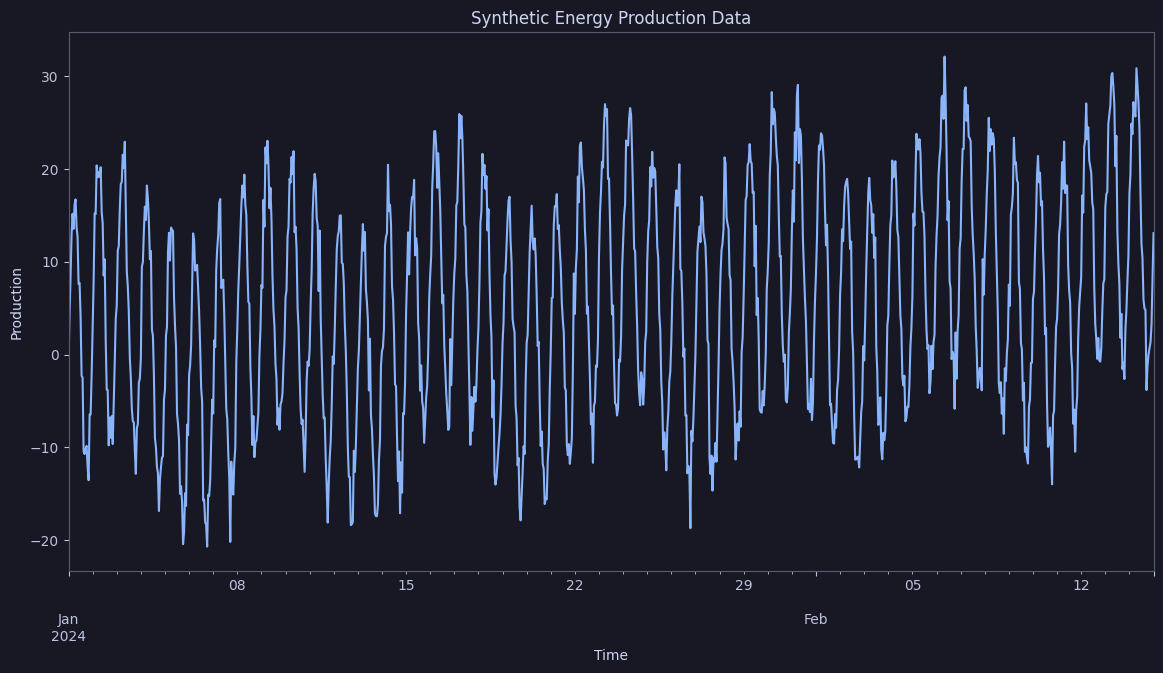


--- ACF and PACF Plots ---


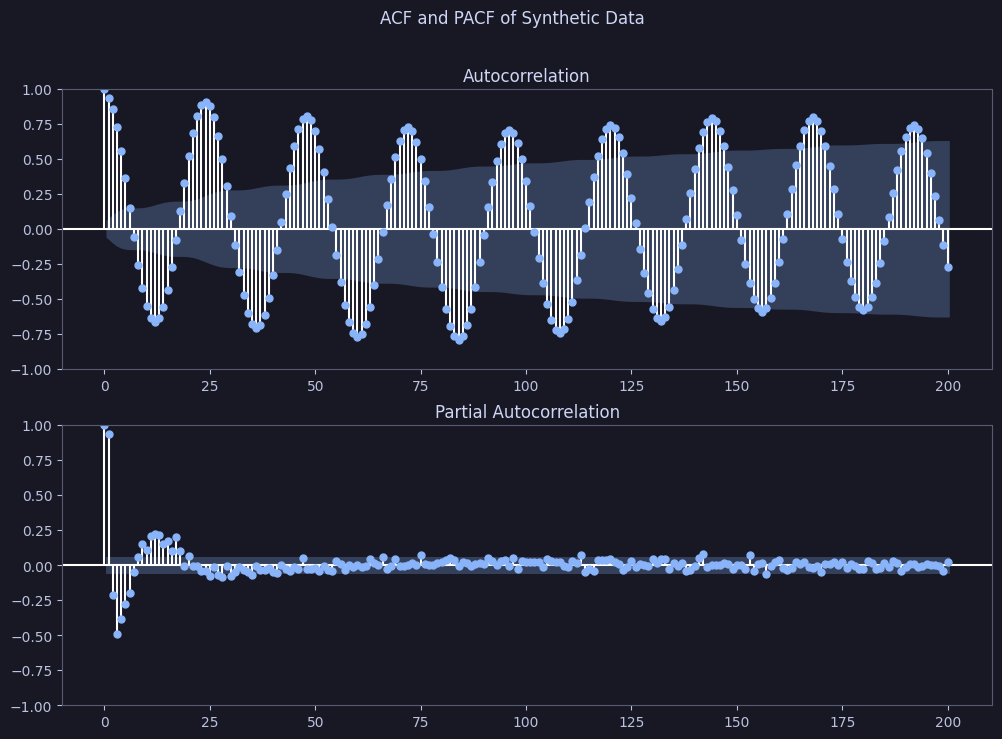


--- Periodogram ---


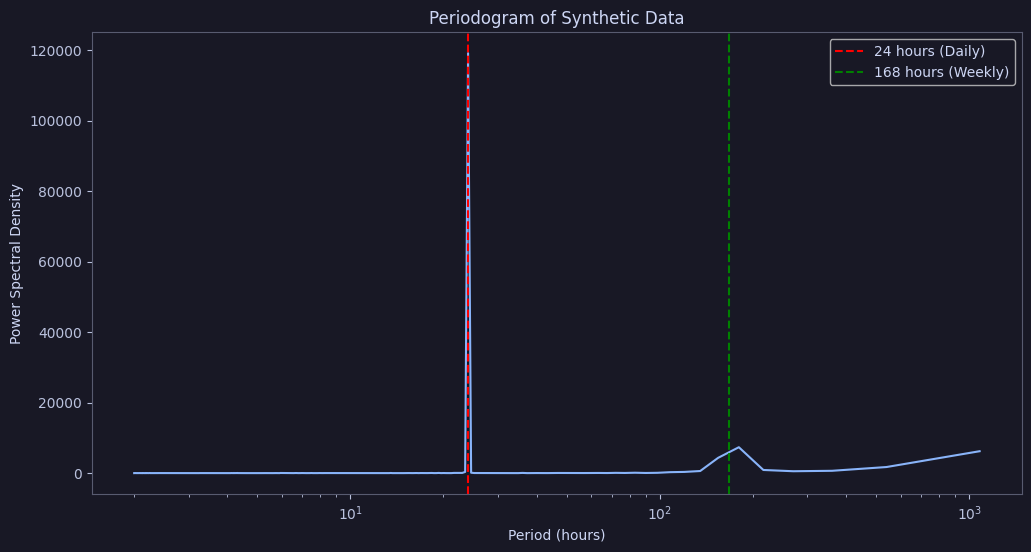


Dominant periods based on periodogram (higher power):
Period: 24.02 hours, Frequency: 0.0416 cycles/hour, Power: 119147.93
Period: 180.17 hours, Frequency: 0.0056 cycles/hour, Power: 7347.46
Period: 1081.00 hours, Frequency: 0.0009 cycles/hour, Power: 6215.10
Period: 154.43 hours, Frequency: 0.0065 cycles/hour, Power: 4336.74
Period: 540.50 hours, Frequency: 0.0019 cycles/hour, Power: 1727.83

--- STL Decomposition (Daily Seasonality) ---


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL

# Generate a time index (e.g., hourly data for a few weeks)
rng = pd.date_range(
    start="2024-01-01",
    end="2024-02-15",
    freq="h",
)  # Approx 6 weeks of hourly data
n_points = len(rng)

# Create components:
# 1. Trend
trend = np.linspace(0, 10, n_points)

# 2. Daily seasonality (24 hours)
daily_seasonality = 15 * np.sin(2 * np.pi * np.arange(n_points) / 24)

# 3. Weekly seasonality (24 * 7 = 168 hours)
weekly_seasonality = 5 * np.sin(2 * np.pi * np.arange(n_points) / 168)

# 4. Noise
noise = np.random.normal(0, 2, n_points)

# Combine components
data = trend + daily_seasonality + weekly_seasonality + noise

# Create pandas Series
series = pd.Series(data, index=rng, name="EnergyProduction")

# --- Plot the generated series ---
plt.figure(figsize=(14, 7))
series.plot(title="Synthetic Energy Production Data")
plt.ylabel("Production")
plt.xlabel("Time")
plt.show()

# --- Now apply the detection methods ---

# 1. ACF/PACF
print("\n--- ACF and PACF Plots ---")
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(series, lags=200, ax=ax[0])  # Lags up to ~8 days (24*8 = 192)
plot_pacf(series, lags=200, ax=ax[1])
plt.suptitle("ACF and PACF of Synthetic Data")
plt.show()

# 2. Periodogram (using SciPy)
print("\n--- Periodogram ---")
# The frequency is in cycles per unit of time.
# If your data is hourly, frequency 1/24 corresponds to a daily cycle.
# Frequency 1/168 corresponds to a weekly cycle.
frequencies, spectrum = periodogram(series, fs=1)  # fs=1 means 1 sample per hour
plt.figure(figsize=(12, 6))
plt.plot(
    1 / frequencies[1:], spectrum[1:]
)  # Plot period (1/frequency) vs spectrum, skip DC component
plt.xscale("log")  # Often helpful to see different scales of periods
plt.xlabel("Period (hours)")
plt.ylabel("Power Spectral Density")
plt.title("Periodogram of Synthetic Data")
# Add vertical lines for expected periods
plt.axvline(24, color="red", linestyle="--", label="24 hours (Daily)")
plt.axvline(168, color="green", linestyle="--", label="168 hours (Weekly)")
plt.legend()
plt.show()

# Highlight dominant frequencies
print("\nDominant periods based on periodogram (higher power):")
sorted_indices = np.argsort(spectrum[1:])[::-1]  # Sort by power, skip DC
for i in range(5):  # Print top 5
    idx = sorted_indices[i]
    freq = frequencies[idx + 1]
    period = 1 / freq
    power = spectrum[idx + 1]
    print(
        f"Period: {period:.2f} hours, Frequency: {freq:.4f} cycles/hour, Power: {power:.2f}"
    )


# 3. STL Decomposition
# For STL, you typically need to specify the main seasonal period you expect.
# Let's first assume we want to isolate the daily seasonality.
print("\n--- STL Decomposition (Daily Seasonality) ---")
stl_daily = STL(
    series, seasonal=24 + 1
)  # seasonal parameter should be odd, so 24+1=25 for daily
# The 'seasonal' parameter in STL is the length of the seasonal smoother.
# It must be odd and is typically chosen based on the primary suspected seasonal period.
# For hourly data and daily seasonality, a common choice is 24*k + 1, where k is small.
# If you suspect a strong 24-hour cycle, seasonal=25 is a good start.
# Or seasonal=seasonal_strength, where seasonal_strength is an odd integer.
# For hourly data with daily seasonality, often seasonal=24*N+1 for some N, like seasonal=25 or seasonal=49.
# Here, `seasonal=25` (assuming we are looking for a period of 24).
# The 'period' argument is the one that directly specifies the periodicity.
# If not specified, it's inferred from the index.
# However, for `STL`, the key parameter is `seasonal` (length of seasonal smoother, must be odd).
# We are looking for a period of 24. `seasonal` should be an odd integer >= 7.
# A common choice is `seasonal = period + (1 if period % 2 == 0 else 0)` or slightly larger.
# For a period of 24, `seasonal=25` or `seasonal=35` (as in Rob Hyndman's examples) are often